# Birth death process with individual evolving birth rates

_Jonathan Lindström_

Consider a birth death process where each particle has it's own parameter $c$. The birth rate for the process is

$\lambda_n = \sum_{i=1}^N \rho(c_i)$

Where $\rho(c) > 0$ for all values of $c$. $\rho(c)$ is a rate function (it gives the birth rate for a particle in the equivalent branching process model).

The death is simply proportional to the number of particles.

$\mu_n = N\mu$

Whenever a new particle is born it gets

$c = c_{parent} + X$ where $X$ is a random variable. $c_{parent}$ is selected from the extant particles with a probability proportional to $\rho(c)$.

## Some properties

Assume that $E[X] = 0$. Let $N$ be large. $f_{c, t}$ is the probaiblity density function for $c$ at time $t$. 

The probability distribution for the selected $c_{parent}$ is proportional to $\rho(c) f_{c, t}(c)$.

For a new particle

$E[c] = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc$

The new particle will slightly alter $f_{c, t}$. After one timestep we get

$E[f_{c, t + dt}] = \frac{N}{N + 1}E[f_{c, t}] + \frac{1}{N + 1}E[c]$

For large $N$ this is approximately

$E[f_{c, t + dt}] = E[f_{c, t}] + \frac{1}{N}E[c]$

The birthrate of new particles is

$\sum_i \rho(c_i)$

which, in this approximation becomes

$N_t \int \rho(c) f_{c,t}(c) dc$

The average waiting time is the inverse of that, so we get:

NOTE this is wrong, gotta take the current value into account to find rate of change

$\frac{dE[f_{c, t}]}{dt} = N_t \int \rho(c) f_{c,t}(c) dc \cdot \frac{1}{N_t}E[c] 
                         = E[c] \int \rho(c) f_{c,t}(c) dc$
                         
or in full:

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc \int \rho(c) f_{c,t}(c) = \int c \rho(c) f_{c, t}(c) dc$

This is difficult to integrate unless we can assume that the shape of $f_{c, t}$ does not change with time.

---

If we exclude the effects of the random variation ($X$), $f_{c, t}$ converges to satisfy

$f_{c, t}(c) \propto \rho(c)f_{c, t}(c)$ 

which has a general solution in the dirac delta function. With noise included we can find the resulting distribution numerically by iterating

$f_{n + 1} = f_X * (f_n \rho)$

---

Some simulations below to test these concepts. I have synchronized births with deaths to reduce the computational burden (killing a cell each time one is born to prevent the population size from changing). However, deaths shouldn't really matter for what is described above.

In [2]:
# Simulation example using a modified Gillespies algorithm
# Not a very good implementation

import numpy as np

class SBP:
    def __init__(self, particles, factor, alpha, beta, perturb):
        # list of floating point numbers specifying 
        # internal parameter for each extant particle
        self.particles = particles
        self.t = 0
        self.factor = factor
        self.alpha = alpha
        self.beta = beta
        self.optimum = 0
        self.perturb = perturb
    
    def simulate(self, increment_time):
        end_time = self.t + increment_time
        while self.t < end_time:
            # calculate rates
            rates = np.array(self.particles)
            rates = self.factor*rates**self.alpha*(1 - rates)**self.beta
            rates[self.particles < 0] = 0
            rates[self.particles > 1] = 0
            
            # increment time dependent on total rate
            # total rate is sum of birth rates + sum of death rates
            total_rate = np.sum(rates)
            self.t += np.random.exponential(1/total_rate)
            
            # replicate random particle
            # normalize rates so that we can use it as probabilities to
            # select the dividing particle
            rates /= np.sum(rates)
            select_particle = np.random.choice(self.particles.size, 1, p=rates)
            select_lambda = self.particles[select_particle]
            self.particles = np.append(self.particles, select_lambda + \
                                       np.random.normal(0, self.perturb))
            
            # kill random particle
            select_particle = np.random.choice(self.particles.size)
            self.particles = np.delete(self.particles, select_particle)
            

0.0013544819439980566
738.2896497300482
[1.]


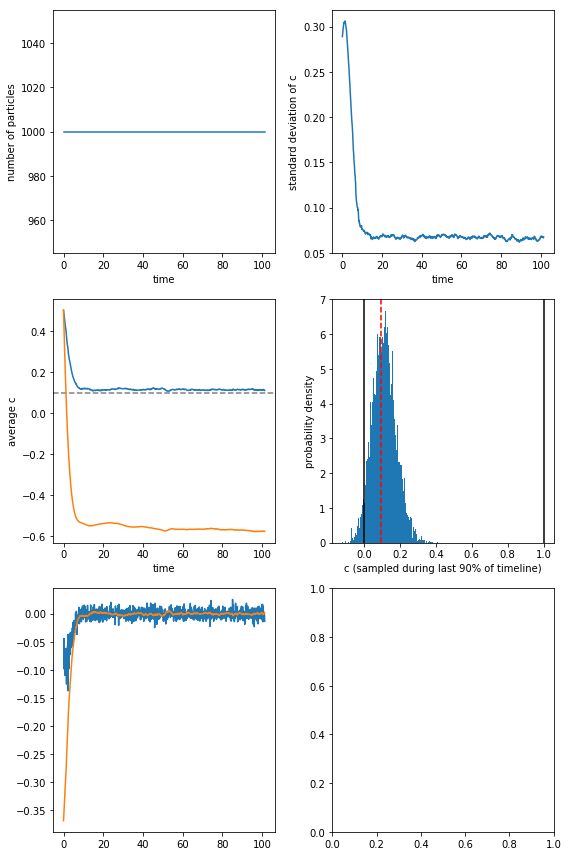

In [69]:
# sample process

import matplotlib.pyplot as plt
from scipy.integrate import simps

# simulate and save data every 0.1 timesteps
T_END = 100
OPTIMUM = 0.5
SIGMA = 0.1
MU = 0.5
ALPHA = 2
BETA = 19
PERTURB = 0.05
NUMBER = 1000
FACTOR = 1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))
print(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))
print(1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA)))
bp = SBP(np.linspace(0, 1, NUMBER), FACTOR, ALPHA, BETA, PERTURB)
bp.optimum = OPTIMUM

def rate(c):
    tmp = np.maximum(c**ALPHA*(1 - c)**BETA, 0)
    tmp[c <= 0] = 0
    tmp[c >= 1] = 0
    return tmp

print(rate(np.array([ALPHA/(ALPHA + BETA)])) * FACTOR)

x = []
N = []
rate_mean = []
rate_variance = []
params = []
theory_derivative = []
theory_integrated = []
for i in range(T_END * 10):
    x.append(bp.t)
    N.append(bp.particles.size)
    rate_mean.append(np.mean(bp.particles))
    rate_variance.append(np.var(bp.particles))
    
    # calculate derivative of mean c according to theory above
    c = np.array(bp.particles)
    r = rate(c)
    r *= FACTOR
    rc = r*c
    theory_derivative.append((np.sum(rc)/np.sum(r) - np.mean(c))*NUMBER/(NUMBER + 1))
    theory_integrated.append(simps(theory_derivative, x=x))
    
    if i > T_END*9:
        params.extend(bp.particles)
    bp.simulate(0.1)
    
x = np.array(x)
rate_mean = np.array(rate_mean)
    
# plot results
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(8, 12)
axs[0][0].plot(x, N)
axs[1][0].plot(x, rate_mean)
axs[1][0].axhline(ALPHA/(ALPHA + BETA), linestyle='--', color='grey')
axs[0][1].plot(x, np.sqrt(rate_variance))
axs[1][1].hist(params, bins=100, density=True)
axs[1][1].axvline(0, color='k')
axs[1][1].axvline(1, color='k')
axs[1][1].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='red')
axs[1][0].plot(x, theory_integrated + rate_mean[0])

num_deriv = (rate_mean[1:] - rate_mean[:-1]) / (x[1:] - x[:-1])
axs[2][0].plot(x[1:] + 0.5*np.mean(x[1:] - x[:-1]), num_deriv)
axs[2][0].plot(x, theory_derivative)

axs[0][0].set_xlabel('time')
axs[0][0].set_ylabel('number of particles')
axs[1][0].set_xlabel('time')
axs[1][0].set_ylabel('average c')
axs[0][1].set_xlabel('time')
axs[0][1].set_ylabel('standard deviation of c')
axs[1][1].set_xlabel('c (sampled during last 90% of timeline)')
axs[1][1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

[0.89489489]


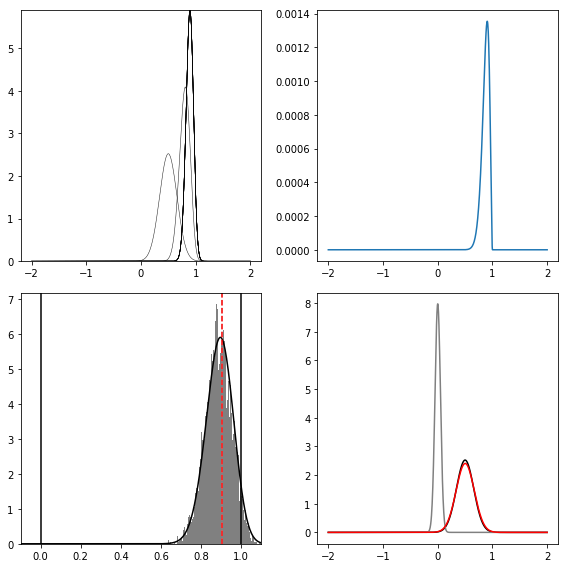

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import matplotlib.cm as cm

# ALPHA = 2
# BETA = 7
ITERS = 100
SKIP = 10
FACTOR = 1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))

def rate(c):
    tmp = np.maximum(c**ALPHA*(1 - c)**BETA, 0)
    tmp[c <= 0] = 0
    tmp[c >= 1] = 0
    return tmp

distributions = []
rates = []
x = np.linspace(-2, 2, 1000)
d = np.exp(-(x - 0.5)**2/0.05)
d /= simps(d, x=x)
distributions.append(d[:])
rates.append(rate(x))
noise = np.exp(-x**2/(2*0.05**2))
noise /= simps(noise, x=x)

for i in range(ITERS - 1):
    d = d*rate(x)*FACTOR
    d = np.convolve(d, noise, mode='same')
    d /= simps(d, x=x)
    
    if i%SKIP != 0:
        continue
    distributions.append(d[:])
    rates.append(rate(x))

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(8, 8)
for i, y1, y2 in zip(range(len(distributions)), distributions, rates):
    axs[0][0].plot(x, y1, color=cm.Greys(int((i + 100)/(len(distributions) + 100)*255)), linewidth=0.5)
    axs[0][0].set_ylim(0, max(axs[0][0].get_ylim()[1], max(y1)))
    
axs[0][1].plot(x, rates[0])
axs[1][0].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='lightgrey')
axs[1][0].plot(x, distributions[-1], color='k')
axs[1][0].set_xlim(-0.1, 1.1)

axs[1][0].hist(params, bins=100, density=True, color='grey')
axs[1][0].axvline(0, color='k')
axs[1][0].axvline(1, color='k')
axs[1][0].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='red')

y1 = distributions[0]
y2 = noise
y3 = np.convolve(y1, y2, mode='same')

y1 /= simps(y1, x=x)
y2 /= simps(y2, x=x)
y3 /= simps(y3, x=x)

axs[1][1].plot(x, y1, color='black')
axs[1][1].plot(x, y2, color='grey')
axs[1][1].plot(x, y3, color='red')


print(x[distributions[-1] == np.max(distributions[-1])])
plt.tight_layout()
plt.show()


$E[f_{c, t + dt}] = \frac{N}{N + 1}E[f_{c, t}] + \frac{1}{N + 1}E[c]$

So the change between two timesteps is

$E[f_{c, t + dt}] - E[f_{c, t}] = \frac{N}{N + 1}E[f_{c, t}] + \frac{1}{N + 1}E[c] - E[f_{c, t}]$

$E[f_{c, t + dt}] - E[f_{c, t}] = \frac{N}{N + 1}E[f_{c, t}] + \frac{1}{N + 1}E[c] - \frac{N + 1}{N + 1}E[f_{c, t}]$

$E[f_{c, t + dt}] - E[f_{c, t}] = \frac{NE[f_{c, t}] + E[c] - (N + 1)E[f_{c, t}]}{N + 1}$

$E[f_{c, t + dt}] - E[f_{c, t}] = \frac{E[c] - E[f_{c, t}]}{N + 1}$

The birthrate of new particles is

$\sum_i \rho(c_i)$

which, in this approximation becomes

$N_t \int \rho(c) f_{c,t}(c) dc$

The change in expectation for one timestep is

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{dt} \frac{E[c] - E[f_{c, t}]}{N + 1}$

The average waiting time is the inverse of the the birthrate, so we get:

$\frac{dE[f_{c, t}]}{dt} = \frac{E[c] - E[f_{c, t}]}{N + 1} N \int \rho(c) f_{c,t}(c) dc$

expand

$\frac{dE[f_{c, t}]}{dt} = \frac{\frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc - \int c f_{c, t}(c) dc}{N + 1} N \int \rho(c) f_{c,t}(c) dc$

$\frac{dE[f_{c, t}]}{dt} = \frac{N}{N + 1} \left[ \int c \rho(c) f_{c, t}(c) dc - \int c f_{c, t}(c) dc \right]$

--- 

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{dt} \left[ E[f_{c, t}] + \frac{1}{N}E[c] - E[f_{c, t}] \right]$

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{dt} \left[ \frac{1}{N}E[c] \right]$

combine

$E[c] = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc$

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{dt} \left[ \frac{1}{N}\frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc \right]$

$\frac{dE[f_{c, t}]}{dt} = N_t \int \rho(c) f_{c,t}(c) dc \frac{1}{N}\frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc$

$\frac{dE[f_{c, t}]}{dt} = \int c \rho(c) f_{c, t}(c) dc$

NOTE this is wrong, gotta take the current value into account to find rate of change

$\frac{dE[f_{c, t}]}{dt} = N_t \int \rho(c) f_{c,t}(c) dc \cdot \frac{1}{N_t}E[c] 
                         = E[c] \int \rho(c) f_{c,t}(c) dc$
                         
or in full:

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc \int \rho(c) f_{c,t}(c) = \int c \rho(c) f_{c, t}(c) dc$


$E[f_{c, t + dt}] = \frac{N}{N + 1}E[f_{c, t}] + \frac{1}{N + 1}E[c]$

For large $N$ this is approximately

$E[f_{c, t + dt}] = E[f_{c, t}] + \frac{1}{N}E[c]$

The birthrate of new particles is

$\sum_i \rho(c_i)$

which, in this approximation becomes

$N_t \int \rho(c) f_{c,t}(c) dc$

The average waiting time is the inverse of that, so we get:

NOTE this is wrong, gotta take the current value into account to find rate of change

$\frac{dE[f_{c, t}]}{dt} = N_t \int \rho(c) f_{c,t}(c) dc \cdot \frac{1}{N_t}E[c] 
                         = E[c] \int \rho(c) f_{c,t}(c) dc$
                         
or in full:

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc \int \rho(c) f_{c,t}(c) = \int c \rho(c) f_{c, t}(c) dc$